# Analyzing Peer Review Data from Asana Comments
**Problem**: My technical writing team has a peer review process where writers review edited content and leave comments on corresponding Asana tasks. Because there is no associated numerical analyses with the process — and because I am at technical writer who loves words — I decided to use some Python and natural language processing to review these comments and find patterns within a year's worth of data. This qualatative analysis can help to determine the effectiveness of the peer review and how it could be improved. 

## Obtaining the Data
I downloaded a `csv` file from Asana that includes all tasks completed by the technical writing team over the past year (Sept. 2021–2022). The results in this file were limited to all tasks with the `Peer Review` tag. This file provides a lot of information about each task; however, you cannot extract task comments from it — and that's where we document peer review results. I used the Asana API to extract task comments.

In [ ]:
# Import pandas to manage the csv file and import the Asana API.
import pandas as pd
import asana

In [ ]:
# Import the original data.
df = pd.read_csv('data.csv')

In [ ]:
# Access the Task ID column in the dataframe for use with the API. A list of IDs is returned.
id_list = df['Task ID'].tolist()
print(id_list)

In [ ]:
# Establish Asana connection.
personal_access_token = <ACCESS_TOKEN>
client = asana.Client.access_token(personal_access_token)

In [ ]:
# Comments are stored as a "story" with the subtype of comment_added. Pull individual comment_added. Data returned as an array of generators.
all_stories = []
for i in id_list:
    stories = client.stories.get_stories_for_task(str(i), opt_pretty=True)
    all_stories.append(stories)
    print(all_stories)

In [ ]:
# A task in this corpus could have multiple comments — not just peer review-related comments.
# Per our process, peer review comments should all begin with "Peer Review", which makes filtering these comments a lot easier.
# Parse the list and get a sample. Then, add results to a dictionary with the date the comment was made.
pr_comment = {"Date":[],"Comment":[]}
for j in all_stories:
    for i in j:
        if i['resource_subtype'] == 'comment_added':
            if 'peer review' in i['text']:
                print(i['text'])
                pr_comment["Date"].append(str(i['created_at']))
                pr_comment["Comment"].append(str(i['text']))
            elif 'Peer Review' in i['text']:
                print(i['text'])
                pr_comment["Date"].append(str(i['created_at']))
                pr_comment["Comment"].append(str(i['text']))


In [ ]:
# Create csv from dictionary.
df = pd.DataFrame.from_dict(pr_comment) 
df.to_csv (r'peer_review_comments.csv', index = False, header=True)

The resulting csv contains two columns: `date` and `comment`. No other information was added in order to keep this analysis deidentified. 

> **Note:** I ended up manually removing the `date` column and creating a "cleaned" file (`peer_review_comments_cleaned.csv`) for use when analyzing. 
>
> A future iteration can use the `date` column to also split the file and create separate quarterly files to look and quarterly progress. 

## Data Analysis for the Whole Year
I will use the `nltk` package to perform keyword extraction and create a word cloud visualization. The text corpus contains a number of words that can be removed for further analysis.

In [ ]:
# Load the exported data file for all data.
filename = 'pr_comments_clean.csv'
file = open(filename, 'rt')
all_data = file.read()
file.close()

### Clean the Data
This function uses the `nltk` package to clean the data by tokenizing the words, making the words lowercase, and filtering stopwords.

In [ ]:
def clean_data(data):
    # Split into words
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(data)
    # Convert to lowercase
    tokens = [w.lower() for w in tokens]
    # Remove punctuation from each word
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # Filter out stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    other_words = ["peer", "review", "feedback", "think", "might", "would", "notes"]
    # You can add in any other words that are meaningless or do not add value to the results
    # For example, "I think" or "I might" showed up in a majority of comments
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if not w in other_words]
    return words



Run the function:

In [ ]:
all_pr = clean_data(all_data)

## Word Cloud Function
This function generates a word cloud for the entire dataset ([StackOverflow source](https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python)). This word cloud represents the most common themes for the past year.

In [ ]:
# Make a word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()



## Word Cloud Representing the Whole Year
Run the function:

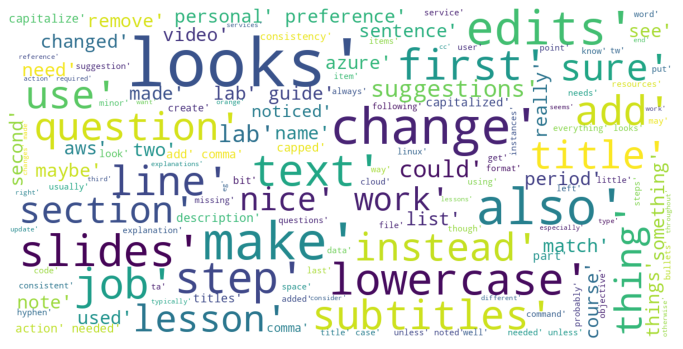

In [ ]:
show_wordcloud(all_pr)

### Frequencies for the Whole Year

In [ ]:
def get_counts(df):
    df = pd.DataFrame(df)
    return df.groupby(df[0])[0].count().sort_values(0, ascending=False).reset_index(name="Count").head(20)

In [ ]:
df_all = get_counts(pd.DataFrame(all_pr))
df_all

/var/folders/9k/83nvv3c57r13xp8hn34dnrk40000gp/T/ipykernel_4504/4227951355.py:3: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  return df.groupby(df[0])[0].count().sort_values(0, ascending=False).reset_index(name="Count").head(20)


,0,Count
0,looks,373
1,edits,173
2,add,163
3,change,163
4,make,160
5,text,156
6,title,145
7,work,144
8,comma,144
9,also,142


## Final Thoughts

The output presents a few common themes:

- Capitalization (e.g, `lowercase`, `capitalize`, `capped`). Many of these issues could have to do with title-casing standards, capitalizing vendor objects (e.g., Availability Zone vs. availability zone), or making common nouns lowercase (e.g., Internet vs. internet). This issue may be due to differences in style guidelines, so it's worth checking if there's any confusion around the standards we're following.
- Writers often make suggestions based on `personal preference`, which is useful feedback, but it may not align with overall team style and objectives.
- `subtitles` come up frequently in the comments, which indicates that there may be some inconsistency or confusion around how we're editing them. We could review our current guidelines or provide more training to ensure everyone is on the same page.
- `title` is also a commmon theme, which is likely related to capitalization issue mentioned earlier.